In [5]:
import os
import pickle
from pychan import FourChan, LogLevel, PychanLogger
from transformers import AutoModelForSequenceClassification
# from transformers import TFAutoModelForSequenceClassification # Removed this line
from transformers import AutoTokenizer, AutoConfig
import numpy as np
import datetime as dt
import pandas as pd
from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup as bs

In [6]:

# With all defaults (logging disabled, all exceptions raised)
fourchan = FourChan()

# Tell pychan to gracefully ignore HTTP exceptions, if any, within its internal logic
fourchan = FourChan(raise_http_exceptions=False)

# Tell pychan to gracefully ignore parsing exceptions, if any, within its internal logic
fourchan = FourChan(raise_parsing_exceptions=False)

# Configure logging explicitly
logger = PychanLogger(LogLevel.INFO)
fourchan = FourChan(logger=logger)

# Use all of the above settings at once
logger = PychanLogger(LogLevel.INFO)
fourchan = FourChan(logger=logger, raise_http_exceptions=True, raise_parsing_exceptions=True)

In [7]:
threads = fourchan.get_threads("sp")
arch_threads = fourchan.get_archived_threads("sp")

[pychan] Fetching archived threads for board /sp/...


In [8]:
ars_thread = []
for i in threads:
  if isinstance(i.title,str):
    if "Arsenal".lower() in i.title.lower() :
      ars_thread.append(i)
for i in arch_threads:
  if isinstance(i.title,str):
    if "Arsenal".lower() in i.title.lower() :
      ars_thread.append(i)

In [9]:
# Define the directory path
data_dir = './4chan_data'
# Ensure the directory exists
os.makedirs(data_dir, exist_ok=True)

# Define the full filename for the pickled object
pickle_filename = os.path.join(data_dir, 'ars_thread' + str(dt.date.today()) + '.pkl' )

# Open the file in binary write mode and pickle the ars_thread object
with open(pickle_filename, 'wb') as f:
    pickle.dump(ars_thread, f)

print(f"'ars_thread' successfully pickled and saved to {pickle_filename}")

'ars_thread' successfully pickled and saved to ./4chan_data\ars_thread2026-02-06.pkl


In [10]:
ars_thread = []
for filename in os.listdir(data_dir):
     if filename.startswith('ars_thread'):
         file_path = os.path.join(data_dir, filename)
         try:
             with open(file_path, 'rb') as f:
                 threads_from_file = pickle.load(f)
                 if isinstance(threads_from_file, list):
                     ars_thread.extend(threads_from_file)
                 else:
                     print(f"Warning: {filename} did not contain a list.")
         except Exception as e:
             print(f"Error reading {filename}: {e}")

print(f"Total threads loaded: {len(ars_thread)}")

Total threads loaded: 20


In [11]:
ars_posts = []
for t in ars_thread:
  ars_posts.extend(fourchan.get_posts(t))

[pychan] Fetching posts for Thread(https://boards.4chan.org/sp/thread/153220324)...


In [12]:
post_data = []
for post in ars_posts:
    post_info = {
        'thread_id': post.thread.number,
        'post_number': post.number,
        'timestamp': post.timestamp,
        'text': post.text,
    }
    post_data.append(post_info)

ars_posts_df = pd.DataFrame(post_data)
ars_posts_df = ars_posts_df.drop_duplicates(subset=["thread_id","post_number"],keep="first")
ars_posts_df = ars_posts_df.sort_values(by="timestamp")
ars_posts_df = ars_posts_df.drop(columns = ["thread_id","post_number"])

In [13]:
ars_posts_df

,timestamp,text
5856,2026-01-31 15:46:00+00:00,Don't you think it must be tough to be an Arse...
5882,2026-01-31 15:55:30+00:00,winningest manager in Arsenal history
5883,2026-01-31 15:55:54+00:00,I have seen enough \n\nARTETA OUT. \n\nThis ty...
5884,2026-01-31 15:56:00+00:00,>>153220324\nFirst for Zubi Dooby Doo
5885,2026-01-31 15:57:53+00:00,Imagine the scenes when Owen Goel scores the w...
...,...,...
260,2026-02-06 21:29:17+00:00,>>153288822\ndubs for a gyok brace check them
261,2026-02-06 21:30:07+00:00,>>153289200\nblessed
262,2026-02-06 21:35:00+00:00,>>153289200\nOk this is based
263,2026-02-06 21:35:31+00:00,>>153289200\nwoah!


In [14]:
data_dir = './4chan_comment_archive'
# Ensure the directory exists
os.makedirs(data_dir, exist_ok=True)

# Define the full filename for the pickled object
pickle_filename = os.path.join(data_dir, 'ars_comments' + str(dt.date.today()) + '.pkl' )

# Open the file in binary write mode and pickle the ars_thread object
with open(pickle_filename, 'wb') as f:
    pickle.dump(ars_posts_df, f)

print(f"'ars_posts_df' successfully pickled and saved to {pickle_filename}")

'ars_posts_df' successfully pickled and saved to ./4chan_comment_archive\ars_comments2026-02-06.pkl


In [15]:
data_dir = './4chan_comment_archive'
for filename in os.listdir(data_dir):
    if filename.startswith('ars_comments'):
        file_path = os.path.join(data_dir, filename)
        try:
            with open(file_path, 'rb') as f:
                comments_df2 = pickle.load(f)
        except Exception as e:
                 print(f"Error reading {filename}: {e}")

In [13]:
def preprocess(text):
    new_text = []
    for t in text.split("\n"):
        t = '' if t.startswith('>>') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
#model.save_pretrained(MODEL)


RobertaForSequenceClassification LOAD REPORT from: cardiffnlp/twitter-roberta-base-sentiment-latest
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 
roberta.pooler.dense.weight     | UNEXPECTED |  | 
roberta.pooler.dense.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [14]:
i = 0
scores_list = []
while i < len(ars_posts_df):
  text_list = ars_posts_df.text.to_list()[i:i+10]
  pp_text_list = []
  for t in text_list:
    pp_text_list.append(preprocess(t))
  encoded_input = tokenizer(pp_text_list, padding=True , truncation=True,  return_tensors='pt')
  output = model(**encoded_input)
  scores = output[0].detach().numpy()
  scores = softmax(scores,axis=1)
  scores[:,2] = scores[:,2] +  scores[:,1]/2
  scores_list.append(scores)
  i += 10
full_array = np.vstack(scores_list)
ars_posts_df["pos_score"] = full_array[:,2]

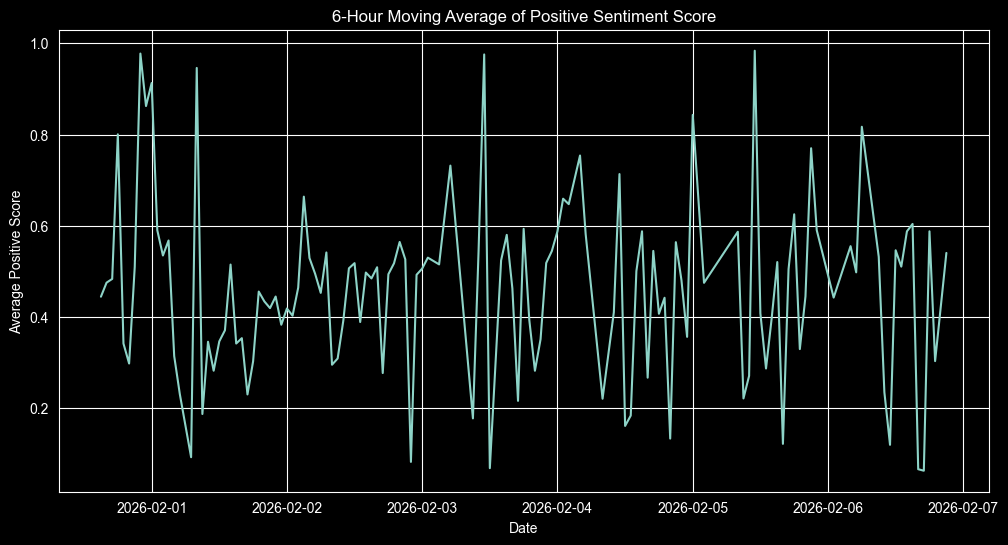

In [22]:
# Ensure timestamp is datetime and set as index
if 'timestamp' in ars_posts_df.columns:
    ars_posts_df['timestamp'] = pd.to_datetime(ars_posts_df['timestamp'])
    # Ensure timestamp is timezone-naive to avoid comparison issues later
    if ars_posts_df['timestamp'].dt.tz is not None:
        ars_posts_df['timestamp'] = ars_posts_df['timestamp'].dt.tz_localize(None)
    ars_posts_df = ars_posts_df.set_index('timestamp')

# Resample every 1 hour and calculate the mean of pos_score
daily_pos_score = ars_posts_df['pos_score'].resample('1h').mean()

# Plotting the 1-hour moving average of pos_score
plt.figure(figsize=(12, 6))
sns.lineplot(x=daily_pos_score.index, y=daily_pos_score.values)
plt.title('6-Hour Moving Average of Positive Sentiment Score')
plt.xlabel('Date')
plt.ylabel('Average Positive Score')
plt.grid(True)
plt.show()

In [16]:
url = 'https://www.soccerbase.com/teams/home.sd'
r = requests.get(url)
soup = bs(r.content, 'html.parser')
teams = soup.find('div', {'class': 'headlineBlock'}, text='Team').next_sibling.find_all('li')

teams_dict = {}
for team in teams:
    link = 'https://www.soccerbase.com' + team.find('a')['href']
    team = team.text

    teams_dict[team] = link


team = []
comps = []
dates = []
h_teams = []
a_teams = []
h_scores = []
a_scores = []

consolidated = []
for k, v in teams_dict.items():
    print('Acquiring %s data...' % k)

    headers = ['Team', 'Competition', 'Home Team', 'Home Score', 'Away Team', 'Away Score', 'Date Keep']
    r = requests.get('%s&teamTabs=results' % v)
    soup = bs(r.content, 'html.parser')

    h_scores.extend([int(i.text) for i in soup.select('.score a em:first-child')])
    limit_scores = [int(i.text) for i in soup.select('.score a em + em')]
    a_scores.extend([int(i.text) for i in soup.select('.score a em + em')])

    limit = len(limit_scores)
    team.extend([k for i in soup.select('.tournament', limit=limit)])
    comps.extend([i.text for i in soup.select('.tournament a', limit=limit)])
    dates.extend([i.text for i in soup.select('.dateTime .hide', limit=limit)])
    h_teams.extend([i.text for i in soup.select('.homeTeam a', limit=limit)])
    a_teams.extend([i.text for i in soup.select('.awayTeam a', limit=limit)])



df = pd.DataFrame(list(zip(team, comps, h_teams, h_scores, a_teams, a_scores, dates)),
                      columns=headers)

Acquiring Wolves data...


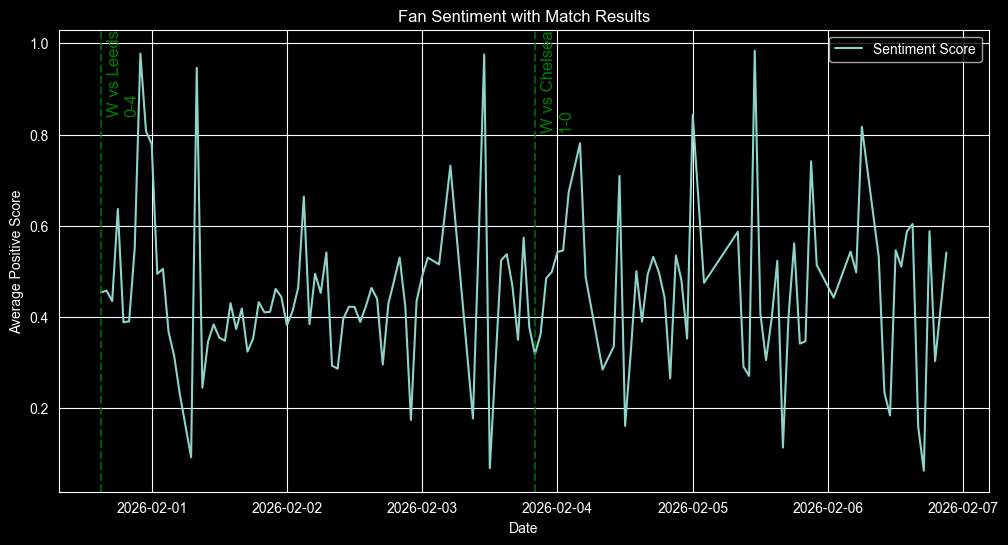

In [21]:
a = df[df.Team=='Arsenal'].copy()
a['Date Keep'] = pd.to_datetime(a['Date Keep'])

# Filter matches that are within the range of the sentiment data
min_date = daily_pos_score.index.min()
max_date = daily_pos_score.index.max()

# Ensure min_date and max_date are timezone naive
if hasattr(min_date, 'tzinfo') and min_date.tzinfo is not None:
    min_date = min_date.tz_localize(None)
if hasattr(max_date, 'tzinfo') and max_date.tzinfo is not None:
    max_date = max_date.tz_localize(None)

matches_in_range = a[(a['Date Keep'] >= min_date) & (a['Date Keep'] <= max_date)]

# Plotting
plt.figure(figsize=(12, 6))

# Ensure daily_pos_score index is naive for plotting
plot_data = daily_pos_score.copy()
if plot_data.index.tz is not None:
    plot_data.index = plot_data.index.tz_localize(None)

sns.lineplot(x=plot_data.index, y=plot_data.values, label='Sentiment Score')

for index, row in matches_in_range.iterrows():
    date = row['Date Keep']
    home_team = row['Home Team']
    away_team = row['Away Team']
    home_score = row['Home Score']
    away_score = row['Away Score']

    is_home = home_team == 'Arsenal'
    if is_home:
        if home_score > away_score:
            color = 'green' # Win
            result = 'W'
        elif home_score < away_score:
            color = 'red' # Loss
            result = 'L'
        else:
            color = 'gray' # Draw
            result = 'D'
        opponent = away_team
    else:
        if away_score > home_score:
            color = 'green' # Win
            result = 'W'
        elif away_score < home_score:
            color = 'red' # Loss
            result = 'L'
        else:
            color = 'gray' # Draw
            result = 'D'
        opponent = home_team

    plt.axvline(x=date , color=color, linestyle='--', alpha=0.7)
    plt.text(date + dt.timedelta(minutes=60), plt.ylim()[1], f"{result} vs {opponent}\n{home_score}-{away_score}",
             rotation=90, verticalalignment='top', fontsize=12, color=color)

plt.title('Fan Sentiment with Match Results')
plt.xlabel('Date')
plt.ylabel('Average Positive Score')
plt.legend()
plt.grid(True)
plt.show()